In [37]:
import copy
%matplotlib inline

import sys
sys.path.append('..')

import xarray as xr
import numpy as np
from pathlib import Path
from itertools import product
import os
import matplotlib.pyplot as plt


In [38]:
data_dir = Path(os.getenv("OODIR"))

In [39]:
def area_average(grid, areas):
    lat_slice = grid.sel(latitude=slice(-90, 90))
    lat_lon_slice = lat_slice.sel(longitude=slice(-180, 180))
    weights = lat_lon_slice[0]
    weights.values = areas
    return lat_lon_slice.weighted(weights).mean(("longitude", "latitude"))

In [40]:
climatology = xr.open_dataset(data_dir / "SST_CCI_climatology" / "SST_1x1_daily.nc")
cos_lat_weights = np.cos(np.deg2rad(climatology.latitude))

# Use the SST values in the climatology as an ocean mask. Set area to 1 for gridcells with SSTs, 0 otherwise
climatology = climatology.sst[0].values
ocean = np.where(np.isnan(climatology), 0.0, 1.0)

# Areas are proportional to the cosine of latitude multiplied by the ocean area in the grid cell
areas = np.zeros((36, 72))
for xx, yy in product(range(72), range(36)):
    areas[yy, xx] = np.mean(ocean[yy*5:(yy+1)*5, xx*5:(xx+1)*5]) * np.cos(np.pi*(yy*5 - 87.5)/180.)

# normalise the areas to one at the equator
areas = areas/np.max(areas)

Comparing subsets of data
=========================

The network of platforms making sea-surface temperature measurements has changed a lot in the past 50 years. It was all ships in the 1970s and now it is largely drifting buoys. This presents a number of difficulties for calculating long-term change in sea surface temperature. First, ships and buoys measure SST in different places and second, they do it in different ways. The first problem isn't too much of a problem on its own, but the second is a probelm and it interacts with the first.

I calculated some subsets of data, by selecting observations for gridding that came from ships, drifting buoys and Argo floats and gridding them separately.

In [41]:
oo_anomalies = xr.open_dataset(data_dir / "IQUAM" / "oo_anomalies.nc")
oo = area_average(oo_anomalies.sst, areas)
oo_time = np.arange(len(oo))/12. + 1981. + 8./12.

In [42]:
oo_ship_anomalies = xr.open_dataset(data_dir / "IQUAM" / "oo_anomalies_ship.nc")
oo_ship = area_average(oo_ship_anomalies.sst, areas)

In [43]:
oo_drifter_anomalies = xr.open_dataset(data_dir / "IQUAM" / "oo_anomalies_drifter.nc")
oo_drifter = area_average(oo_drifter_anomalies.sst, areas)

In [44]:
oo_argo_anomalies = xr.open_dataset(data_dir / "IQUAM" / "oo_anomalies_argo.nc")
oo_argo = area_average(oo_argo_anomalies.sst, areas)

(-0.5, 0.65)

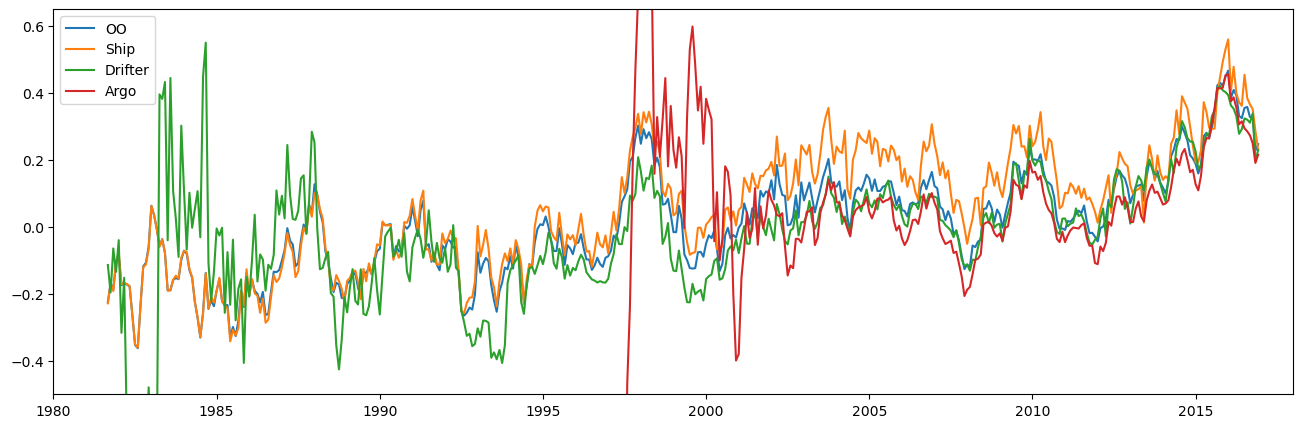

In [45]:
plt.figure()
plt.gcf().set_size_inches(16,5)
plt.plot(oo_time, oo, label='OO')
plt.plot(oo_time, oo_ship, label='Ship')
plt.plot(oo_time, oo_drifter, label='Drifter')
plt.plot(oo_time, oo_argo, label='Argo')
plt.legend()
plt.xlim(1980, 2018)
plt.ylim(-0.5, 0.65)

I calculated the time series of global mean SST anomalies from each of these subsets and these are plotted above. There are a bunch of things to see in this plot. 

First, the drifter-only line and argo-only line have very high variability at the start of each record (1981 for the drifters and 1997 for the Argo floats). This is because it took a while for these networks to build up to their optimal coverage. In the case of the drifters, this didn't really happen until 2005. Argo reached full coverage much more quickly, with quasi global coverage around 2004.

Second, the dataset labelled OO contains all the observations in the IQUAM dataset (ships, drifters, moorings and argo floats, plus a few others). In 1981, the OO line and the ship-only line are identical. In 2010, the OO line is much closer the drifter-only line. This reflects two things: the ship data are biased warm relative to the drifters and the balance of the network has tipped from all ships in the 1970s to mostly drifters (and Argo) today. 

The warmg bias between ships and drifters can be estimated by taking the difference between the two series shown above.

(-0.2, 0.4)

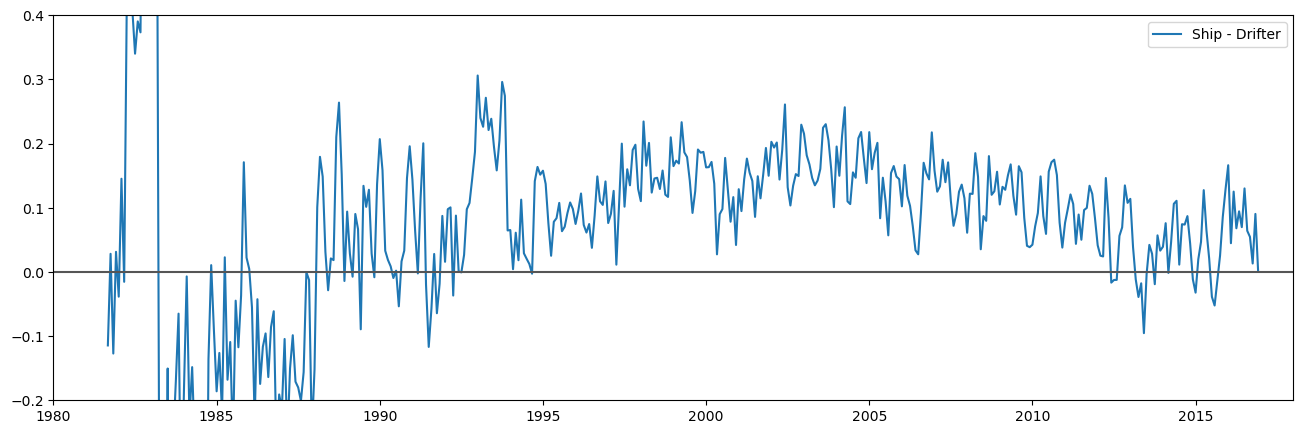

In [46]:
plt.figure()
plt.gcf().set_size_inches(16,5)
plt.plot(oo_time, oo_ship - oo_drifter, label='Ship - Drifter')
plt.plot([1980,2018],[0,0],color='#555555')
plt.legend()
plt.xlim(1980, 2018)
plt.ylim(-0.2, 0.4)

The difference series has high variability in the early part, which is due to the low coverage of the drifter data, but by the late 1990s, there's a clear warm bias in the ship data.

In [47]:
n_cell_oo = np.count_nonzero(~np.isnan(oo_anomalies.sst.values), axis=(1,2))
n_cell_ship = np.count_nonzero(~np.isnan(oo_ship_anomalies.sst.values), axis=(1,2))
n_cell_drifter = np.count_nonzero(~np.isnan(oo_drifter_anomalies.sst.values), axis=(1,2))

(1980.0, 2018.0)

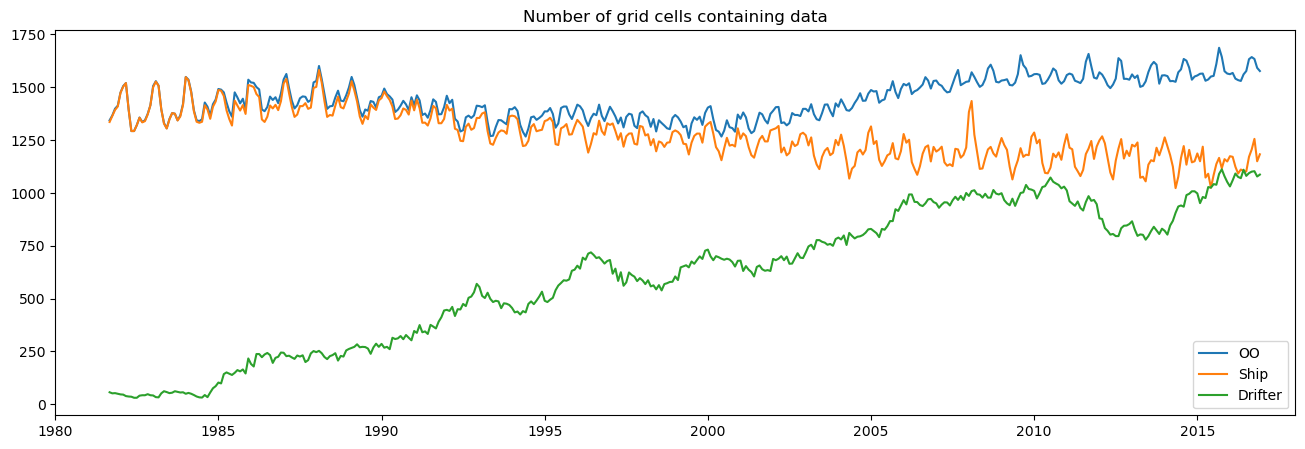

In [48]:
plt.figure()
plt.gcf().set_size_inches(16, 5)
plt.plot(oo_time, n_cell_oo, label='OO')
plt.plot(oo_time, n_cell_ship, label='Ship')
plt.plot(oo_time, n_cell_drifter, label='Drifter')
plt.legend()
plt.title('Number of grid cells containing data')
plt.xlim(1980, 2018)

The decline in the ship network and the growth of the drifter network is fairly clear (see above). You can also see a seasonal cycle in the coverage of the ship data. 

The coverage of the two is different and changed over time so we need to account for that when looking at the ship-drifter difference. The easiest way to do that is to colocate the data to only calculate the time series where both subsets have data.

In [49]:
combined_missing = np.isnan(oo_ship_anomalies.sst.values) | np.isnan(oo_drifter_anomalies.sst.values)

coloc_ship = copy.deepcopy(oo_ship_anomalies)
coloc_ship.sst.values[combined_missing] = np.nan
coloc_drifter = copy.deepcopy(oo_drifter_anomalies)
coloc_drifter.sst.values[combined_missing] = np.nan

oo_ship_coloc = area_average(coloc_ship.sst, areas)
oo_drifter_coloc = area_average(coloc_drifter.sst, areas)

(-0.5, 0.5)

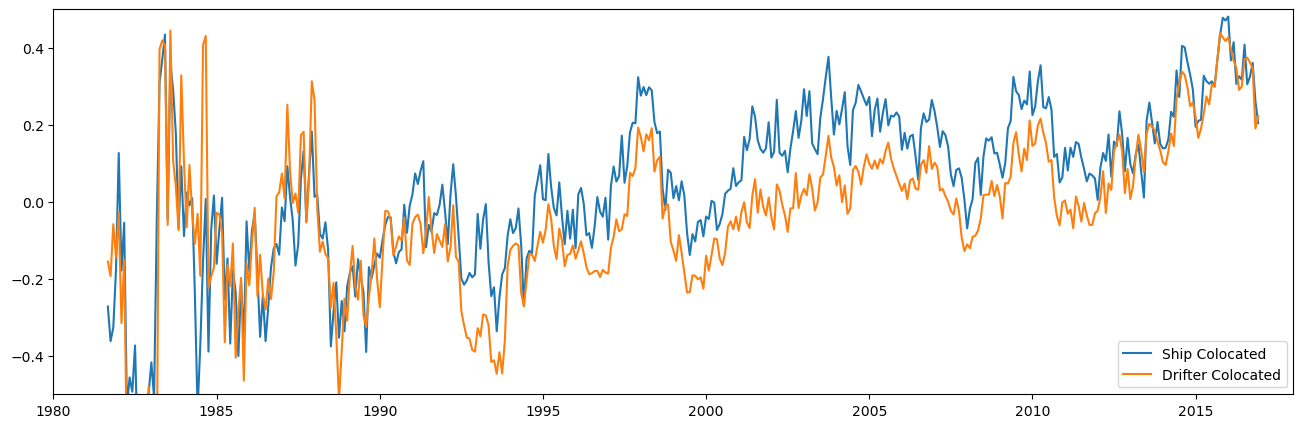

In [50]:
plt.figure()
plt.gcf().set_size_inches(16,5)
plt.plot(oo_time, oo_ship_coloc, label='Ship Colocated')
plt.plot(oo_time, oo_drifter_coloc, label='Drifter Colocated')
plt.legend()
plt.xlim(1980, 2018)
plt.ylim(-0.5, 0.5)

(-0.2, 0.4)

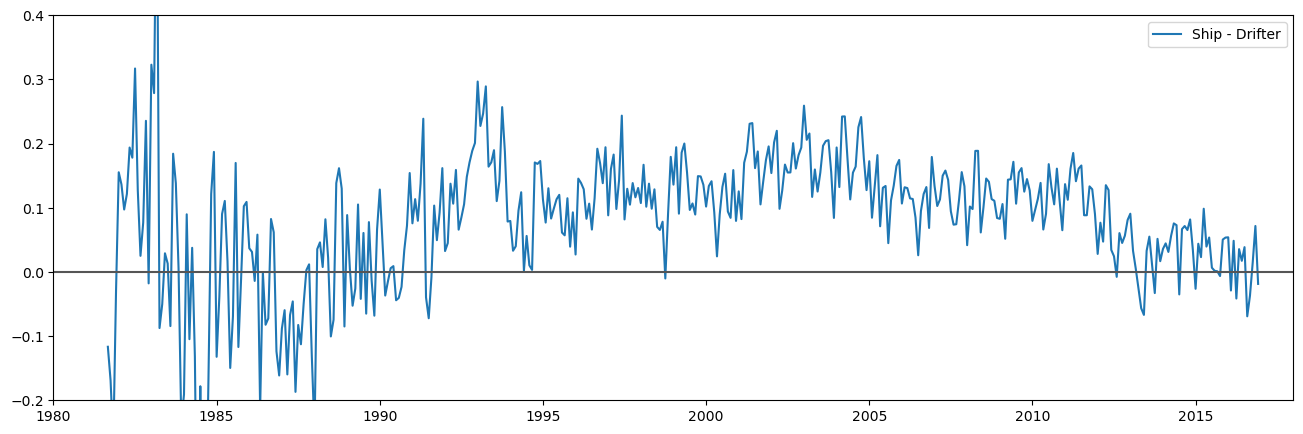

In [51]:
plt.figure()
plt.gcf().set_size_inches(16,5)
plt.plot(oo_time, oo_ship_coloc - oo_drifter_coloc, label='Ship - Drifter')
plt.plot([1980,2018],[0,0],color='#555555')
plt.legend()
plt.xlim(1980, 2018)
plt.ylim(-0.2, 0.4)

The colocation smoothes out some of the differences between the two groups. There's still a lot of noise in the early comparison because the obs cover such a small fraction of the ocean. A smaller area means inherently higher variability but it also means fewer observations and hence more measurement error. The offset between the two is... Ooooh I can caluclate it:

In [52]:
print(np.mean(oo_ship_coloc - oo_drifter_coloc))

<xarray.DataArray 'sst' ()> Size: 8B
array(0.08021313)


It's a bit less than a tenth of a degree. That gives us a first estimate of the size of the artificial cooling associated with the transition from ships to buoys: a bit less than a tenth of a degree. That's not quite the whole story because, as you can see, the offset isn't constant. The ship network is also made up of ships using different measurement methods which each have distinctive biases (that change over time) and the relative proportions of ships using those different methods change over time too. There's a drop in the difference around 2012, with ships being less biased afterwards. This is consistent with what we saw in the HadSST4 development. It's more pronounced in the southern hemisphere, where it has more of the character of a step change (reasons unknown) than in the north, where it was more gentle. The larger number of ships in the northern hemisphere means that the biases are likely to be more consistent in time.